**#SEMINAIRE BIGDATA/AI CREATION D'UN MODEL DE RECONNAISSANCE D'IMAGES**

by Cyril Cohen Solal v24.06

Ce notebook est un exemple d'utilisation du deep learning avec la bibliothèque FastAI, qui est basée sur PyTorch. **FastAI** permet de créer simplement et efficacement un modèle de reconnaissance d'images. Grâce à ses abstractions et à ses fonctionnalités avancées, même ceux qui ne sont pas experts en machine learning peuvent construire des modèles performants avec un minimum d'efforts. Nous allons parcourir les étapes nécessaires pour créer un modèle de reconnaissance d'images, depuis la préparation des données jusqu'à l'évaluation du modèle.

Basé sur les exemples de FASTAI: ex: https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb


# 1/ Choix du scénario :
Nous allons choisir trois classes (différents types d'objets) pour lesquelles nous souhaitons créer un modèle de reconnaissance.

In [8]:
#
#DEFINITION DES DIFFERCLASSES
#
diffclass = 'water bottle','wine bottle','champagne bottle'

# 2/ Librairies :
Importation des librairies nécessaires pour créer notre modèle.

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


Mounted at /content/gdrive


In [13]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Importation et initialisation de l'acces à Search Images Bing

# 3/ Récupération des images & Création de notre "block" images:
Nous allons rechercher des images représentant les classes en utilisant l'API proposée par Azure.
Replacer XXX par votre Clef azure en créant un compte sur https://www.microsoft.com/en-us/bing/apis/bing-web-search-api

In [42]:
from google.colab import userdata
azureKey=userdata.get('azureKey')
#azureKey='XXX' use this line instead of the rpevious line to put your key
key = os.environ.get('AZURE_SEARCH_KEY', azureKey)

In [15]:
#SEARCH IMAGE WITH BING
path = Path('img')
if not path.exists():
    path.mkdir() # CREATE MAIN FOLDER IMG
    print(diffclass)
    for classe in diffclass:
        dest = (path/classe)
        print('Class:', dest)
        dest.mkdir(exist_ok=True) # CREATE SUBFOLDER FOR EACH CLASS
        results = search_images_bing(key, f'{classe}') # SEARCH IMAGES URL FOR EACH CLASS
        download_images(dest, urls=results.attrgot('contentUrl')) # DOWNLOAD IMAGES IN FOLDER

('water bottle', 'wine bottle', 'champagne bottle')
Class: img/water bottle
Class: img/wine bottle
Class: img/champagne bottle


In [28]:
#CHECK & REMOVE FAILED IMAGES
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);


In [29]:
#PREPARE THE DATA
# Create a DataBlock, which is a high-level API for building and managing datasets
imgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # This defines the types of data for the inputs and outputs:
    get_items=get_image_files, #This function is used to retrieve the items (images) from the file system. get_image_files is a FastAI utility function that finds all image files in the specified directory.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  #This specifies how to split the dataset into training and validation sets
    get_y=parent_label, #his function is used to extract the labels for the images from the parent directory of each image
    item_tfms=Resize(128)) #This specifies the transformations to apply to each item (image) Resizes each image to 128x128 pixels. This is a basic preprocessing step to ensure that all images have the same size, which is necessary for training a neural network.

# 4/ Analyse des images & création d'autres images :
Nous allons examiner la pertinence des images et en générer d'autres grâce à des outils de transformation.

In [30]:
dls = imgs.dataloaders(path)

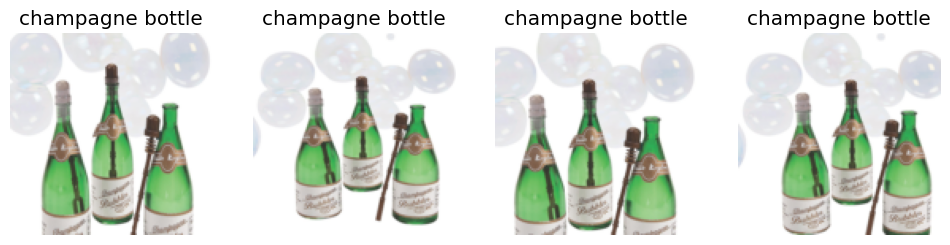

In [31]:
# MULTI SCALE - Apply random resized crop transformation to the images
imgs = imgs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

# Create DataLoaders from the DataBlock
dls = imgs.dataloaders(path)

# Display a batch of training images
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# show_batch: This method displays a batch of images from the training set.
# max_n=4: Show a maximum of 4 images.
# nrows=1: Arrange the images in a single row.
# unique=True: Ensure that the images displayed are unique.

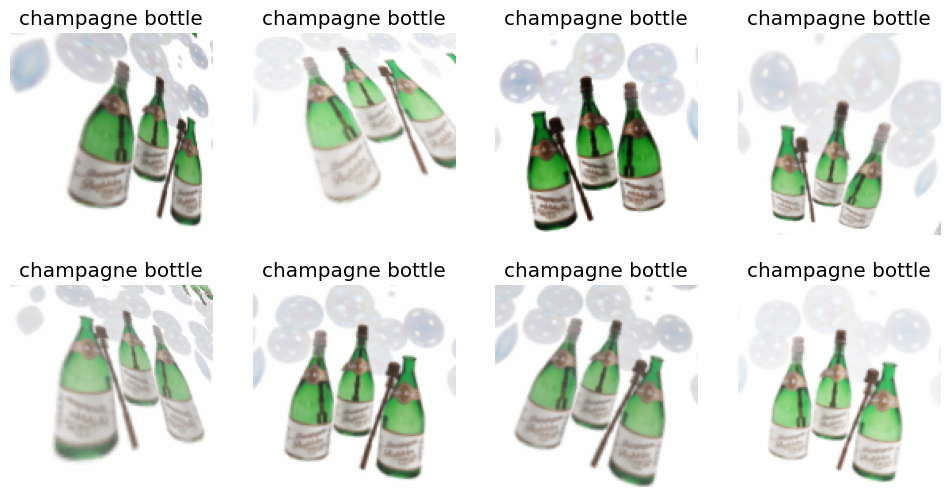

In [32]:
# TRANSFORMATION
imgs = imgs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = imgs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

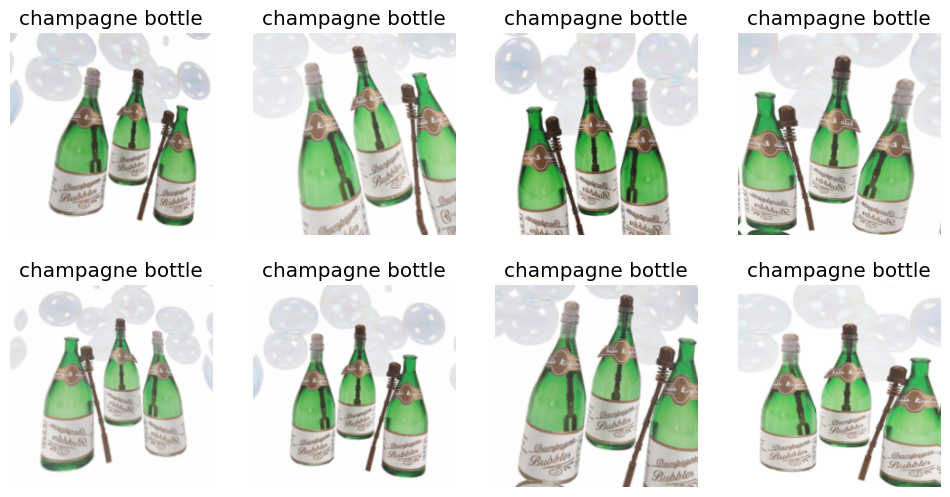

In [33]:
# RESIZED CROP
imgs = imgs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = imgs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# 5/ Entraînement du modèle :
Nous allons utiliser le modèle ResNet-18, un réseau de neurones convolutifs pré-entraîné, pour notre tâche de classification. Ce modèle est connu pour sa profondeur modérée et son efficacité sur diverses tâches de vision par ordinateur.
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
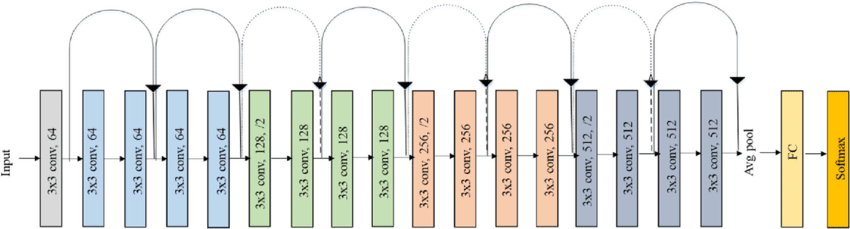

---



In [34]:
# Create a vision learner with the dataloaders, using the resnet18 model and tracking the error rate as a metric
learn = vision_learner(dls, resnet18, metrics=error_rate)
#vision_learner: This is a FastAI function that creates a learner object for computer vision tasks.
#dls: This is the DataLoaders object created from the DataBlock, which provides the training and validation datasets.
#resnet18: This is the architecture of the pre-trained model being used (ResNet-18).
#metrics=error_rate: This specifies that the error rate (1 - accuracy) should be used as the evaluation metric during training.

# Fine-tune the model for 4 epochs to improve its performance on the new dataset
learn.fine_tune(4)
#fine_tune: This method fine-tunes the model, which involves training the pre-trained model on the new dataset.
#4: This specifies the number of epochs to fine-tune the model. An epoch is one complete pass through the entire training dataset. Fine-tuning for 4 epochs means the model will be trained on the dataset 4 times.

epoch,train_loss,valid_loss,error_rate,time
0,1.923317,1.363309,0.461538,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.978026,0.986765,0.410256,00:24
1,0.853620,0.622185,0.230769,00:24
2,0.685787,0.502255,0.205128,00:26
3,0.572905,0.478486,0.192308,00:26


# 6/ Analyse des erreurs :
Grâce à la matrice de confusion, qui permet de visualiser les performances du modèle en comparant les prédictions aux véritables étiquettes, et à l'affichage des erreurs du modèle, nous allons comprendre les points problématiques.

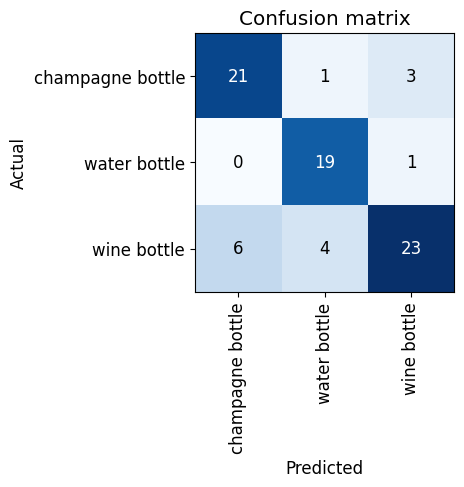

In [35]:
# Create a ClassificationInterpretation object from the learner to analyze the model's predictions
interp = ClassificationInterpretation.from_learner(learn)
# ClassificationInterpretation: This is a FastAI class used to interpret the results of a classification model.
# from_learner: This method creates an interpretation object from the provided learner (in this case, 'learn').

# Plot the confusion matrix to visualize the performance of the model
interp.plot_confusion_matrix()
# plot_confusion_matrix: This method generates a confusion matrix plot, which shows the number of correct and incorrect predictions for each class. This helps in understanding the types of errors the model is making.


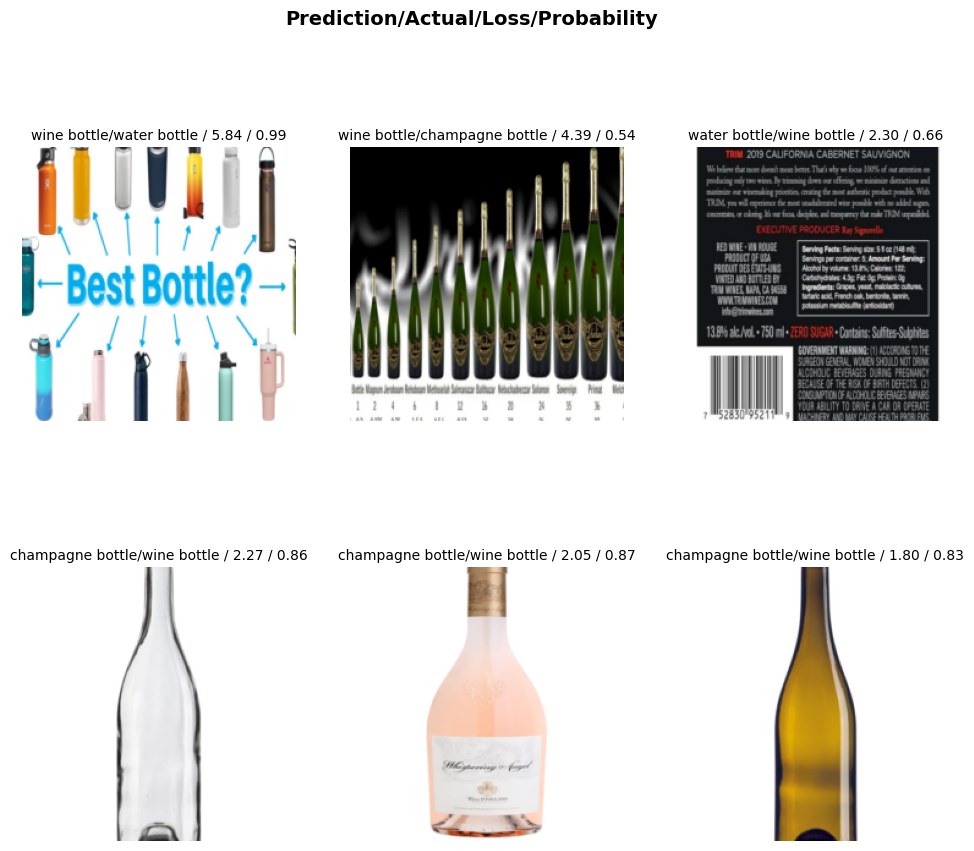

In [41]:
# Plot the top losses to analyze the most incorrect predictions made by the model
plt.rcParams.update({'axes.titlesize': 'small',   # Font size for the title
                     'axes.labelsize': 'small',   # Font size for the x and y labels
                     'xtick.labelsize': 'small',  # Font size for the x tick labels
                     'ytick.labelsize': 'small'}) # Font size for the y tick labels
interp.plot_top_losses(6, nrows=2, figsize=(12, 10))
# plot_top_losses: This method plots the images with the highest losses (most incorrect predictions) made by the model.
# 6: This specifies the number of images with the highest losses to plot.
# nrows=2: This specifies the number of rows in the plot layout. In this case, the 6 images will be arranged in 2 rows.
# Loss: Error measure indicating how wrong the model's prediction is.
# Probability: Model's confidence in its prediction.

# 7/ Correction des images sources :
Possibilité de corriger les images sources pour améliorer les performances du modèle.

In [37]:
#hide_output
# Hide the output cell to keep the notebook clean
# Create an ImageClassifierCleaner to interactively clean the data by identifying and correcting mislabeled images
cleaner = ImageClassifierCleaner(learn)
# ImageClassifierCleaner: This is a FastAI tool for interactively cleaning the dataset by identifying mislabeled or incorrect images.
# learn: The learner object used to create the cleaner.

# Display the ImageClassifierCleaner widget for interactive use
cleaner


# 8/ Test de notre modèle :
Nous allons tester notre modèle avec des images extérieures pour évaluer sa robustesse et sa capacité à généraliser.

In [38]:
# Hide the output cell to keep the notebook clean
# Create widgets for file upload, output display, label prediction, and classification button
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_classify = widgets.Button(description='Classify')

# Function to handle the button click event for classification
def on_click_classify(change):
    # Create an image from the uploaded file
    img = PILImage.create(btn_upload.data[-1])
    # Clear the output display
    out_pl.clear_output()
    # Display the image thumbnail in the output display
    with out_pl:
        display(img.to_thumb(128, 128))
    # Make a prediction using the learner
    pred, pred_idx, probs = learn.predict(img)
    # Update the label with the prediction and its probability
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

# Attach the event handler to the classify button
btn_classify.on_click(on_click_classify)

# Arrange the widgets in a vertical box layout
display(VBox([
    widgets.Label('Select your test image:'),
    btn_upload,
    btn_classify,
    out_pl,
    lbl_pred
]))
